# Demonstartion of Data structure and overview


In [3]:
import os
import time
import numpy as np
import nibabel as nib
from nilearn import masking, signal, plotting, image
from nilearn.maskers import NiftiMasker
import cebra
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('always')
import seaborn as sns
from scipy import stats, signal
from tqdm.notebook import tqdm

In [4]:
#Caching
CACHE_DIR = Path("./cebra_cache")
# Configuration parameters
CONFIG = {
    'nifti_file': "./raw_data/ds001338-download/sub-tb2994/func/sub-tb2994_task-story1_bold.nii.gz",  # One sample for demo purpose
    'tr': 1.0,
    'window_size': 15,
    'output_dim': 3,
    'random_state': 42,
    'device': 'mps'
}

In [5]:
def load_and_preprocess_fmri(nifti_path, mask_img=None, standardize=True,
                             cache_name="preprocessed_timeseries.npy"):
    """Load fMRI data with caching to avoid recomputation."""

    cache_path = CACHE_DIR / cache_name
    masker_path = CACHE_DIR / "masker.pkl"

    # Check if we have cached results
    if cache_path.exists() and masker_path.exists():
        print("Loading preprocessed data from cache...")
        time_series = np.load(cache_path)
        with open(masker_path, 'rb') as f:
            masker = pickle.load(f)
        print(f"Loaded cached data: {time_series.shape}")
        return time_series, masker

    print("Preprocessing fMRI data...")

    # Create masker for extracting time series
    masker = NiftiMasker(
        mask_img=mask_img,
        standardize=standardize,
        detrend=True,
        low_pass=0.1,
        high_pass=0.01,
        t_r=CONFIG['tr'],
        memory='nilearn_cache',
        memory_level=1,
        verbose=1
    )

    # Load and mask the data
    time_series = masker.fit_transform(nifti_path)

    # Save to cache
    np.save(cache_path, time_series)
    with open(masker_path, 'wb') as f:
        pickle.dump(masker, f)

    print(f"Time series shape: {time_series.shape}")
    print(f"Data cached to: {cache_path}")

    return time_series, masker

In [6]:
# execute loading
time_series, masker = load_and_preprocess_fmri(CONFIG['nifti_file'])

Loading preprocessed data from cache...
Loaded cached data: (526, 725886)


 # Data Inspection Functions

## Raw Data Inspection

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 48
dim             : [  4 110 110  60 526   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 59
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 109.0
qoffset_y       : -124.0
qoff

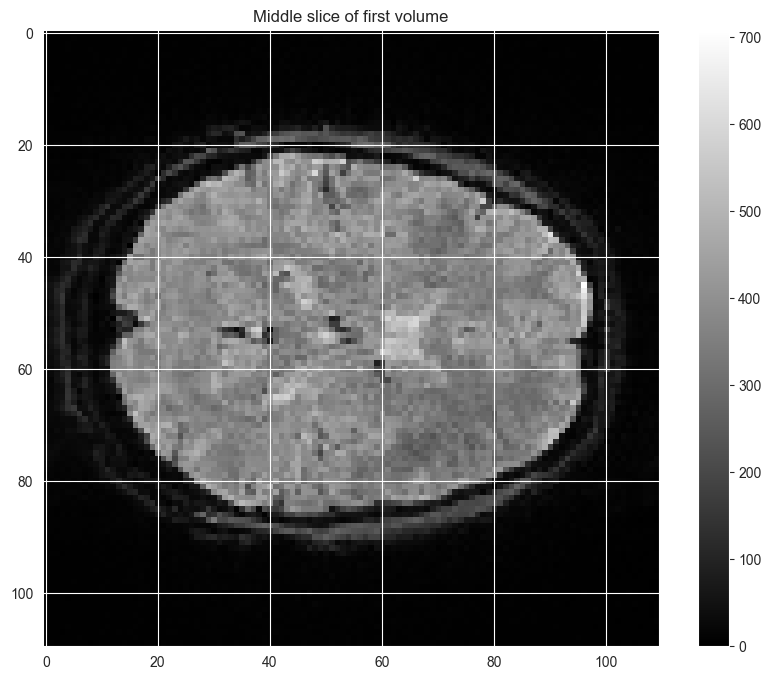

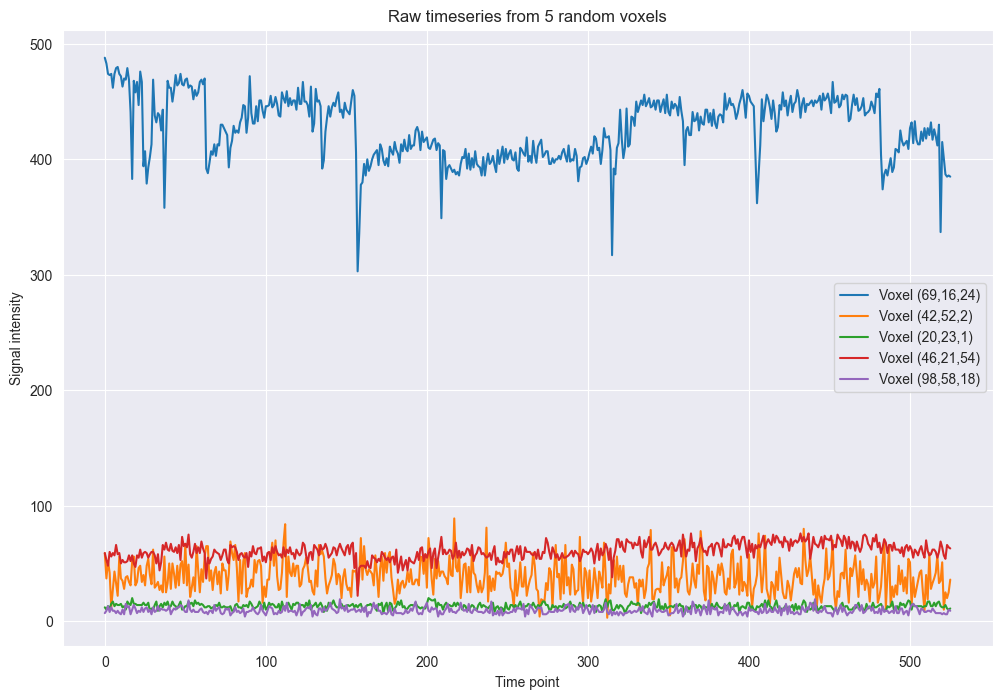

In [11]:
img = nib.load(CONFIG['nifti_file'])
header = img.header
print(header)

# Look for descriptions in the header
if hasattr(img, 'get_filename'):
    print(f"Filename: {img.get_filename()}")

# Check data type and scale
print(f"Data type: {header.get_data_dtype()}")
print(f"Scl_slope: {header['scl_slope']}")


# Load data
img = nib.load(CONFIG['nifti_file'])
data = img.get_fdata()

# Plot middle slice of first volume
middle_z = data.shape[2] // 2
plt.figure(figsize=(10, 8))
plt.imshow(data[:, :, middle_z, 0], cmap='gray')
plt.colorbar()
plt.title("Middle slice of first volume")
plt.show()

# Plot timeseries from a few random voxels
n_timepoints = data.shape[3]
time = np.arange(n_timepoints)
plt.figure(figsize=(12, 8))
for i in range(5):  # 5 random voxels
    x = np.random.randint(0, data.shape[0]-1)
    y = np.random.randint(0, data.shape[1]-1)
    z = np.random.randint(0, data.shape[2]-1)
    plt.plot(time, data[x, y, z, :], label=f'Voxel ({x},{y},{z})')
plt.legend()
plt.title("Raw timeseries from 5 random voxels")
plt.xlabel("Time point")
plt.ylabel("Signal intensity")
plt.show()

## Brain Imaging

/opt/miniconda3/envs/cebra/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



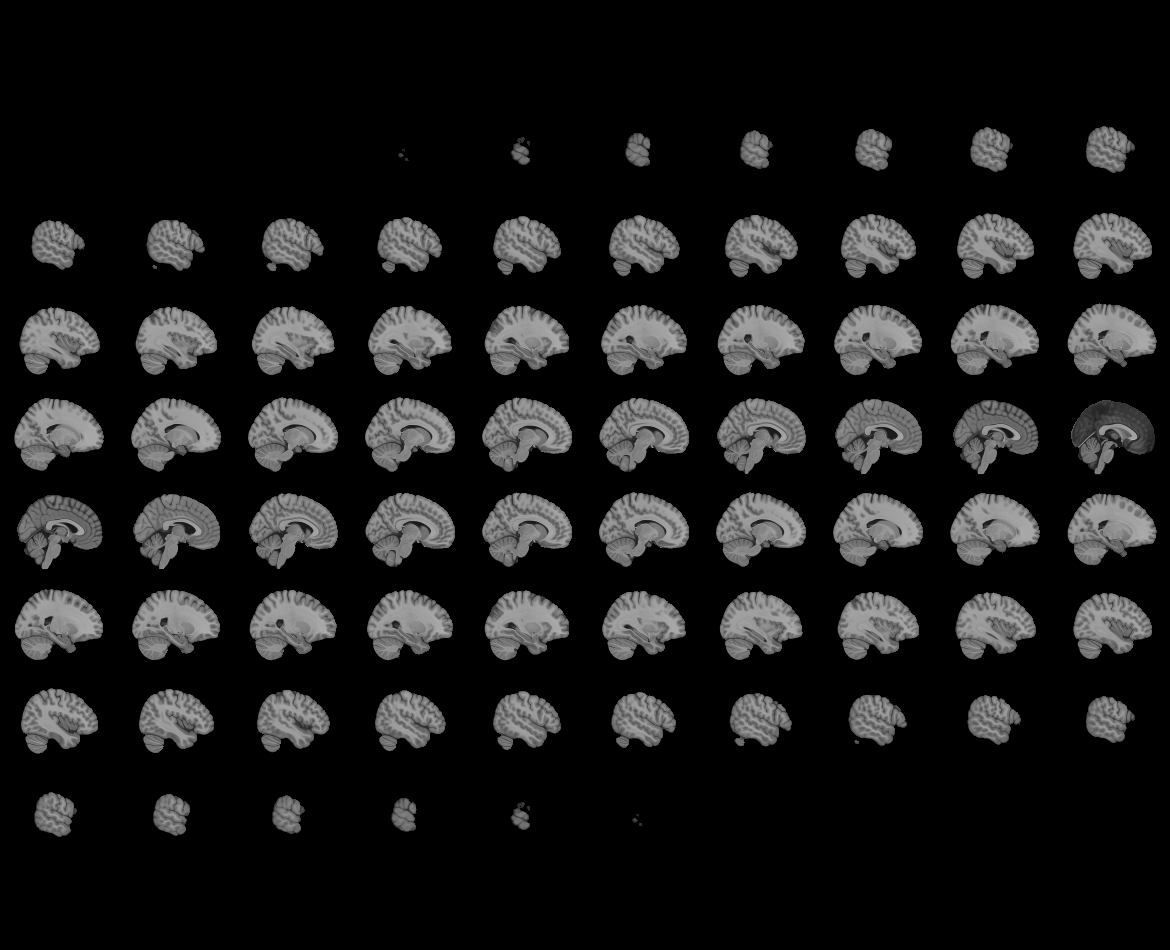
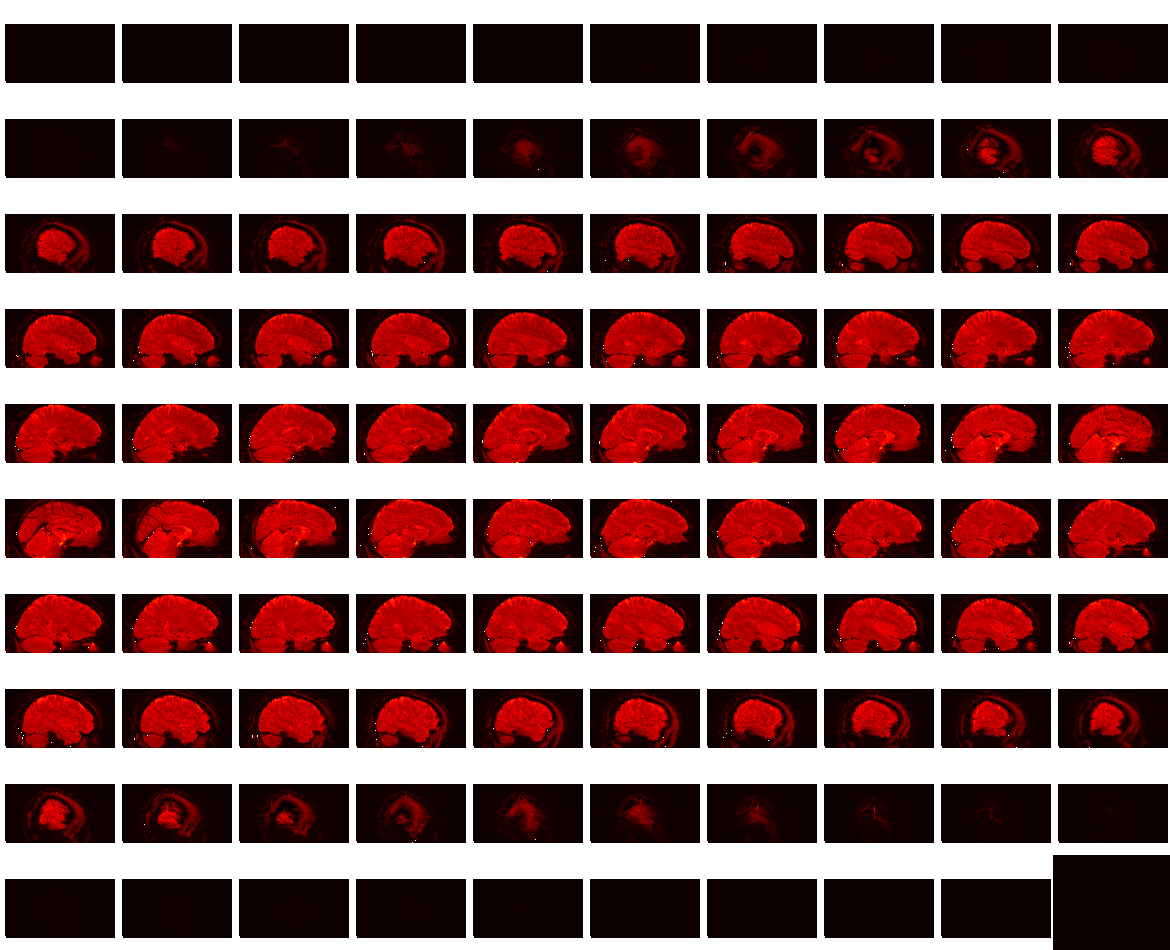

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [35]:
from nilearn import plotting
import nibabel as nib

# Load the image
img = nib.load(CONFIG['nifti_file'])

# Get the first volume to check dimensions
if len(img.shape) == 4:
    # Extract just the first 3D volume to see if that works
    from nilearn.image import index_img
    first_vol = index_img(img, 0)
    viewer = plotting.view_img(first_vol)
    display(viewer)

    # Then you can try adding the slider manually:
    plotting.plot_img(img, display_mode='ortho', cut_coords=None)

In [11]:
# Install if needed
# !pip install ipyvolume

import ipyvolume as ipv
import ipython_genutils
import nibabel as nib
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Load the 4D fMRI data
img = nib.load('your_file.nii.gz')
data = img.get_fdata()
nx, ny, nz, nt = data.shape

# Setup the 3D viewer
fig = ipv.figure()
ipv.style.use('light')

# Prepare initial volume for visualization
current_vol = data[:,:,:,0]

# Normalize data for better visualization
def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, [1, 99])
    vol_norm = (vol - vmin) / (vmax - vmin)
    vol_norm = np.clip(vol_norm, 0, 1)
    return vol_norm

# Create the volume plot
volume = ipv.volshow(normalize_volume(current_vol),
                     extent=[[0, nx], [0, ny], [0, nz]],
                     level=[0.1, 0.5, 0.9],  # Multiple isosurface levels
                     opacity=[0.01, 0.05, 0.1])  # Opacity for each level

# Create time slider
time_slider = widgets.IntSlider(
    min=0, max=nt-1, value=0,
    description='Time:',
    continuous_update=False
)

# Function to update the volume based on time
def update_time(change):
    t = change['new']
    new_vol = normalize_volume(data[:,:,:,t])
    ipv.volshow(new_vol,
                extent=[[0, nx], [0, ny], [0, nz]],
                level=[0.1, 0.5, 0.9],
                opacity=[0.01, 0.05, 0.1])
    ipv.gcf()

# Connect the slider to the update function
time_slider.observe(update_time, names='value')

# Display the widget
controls = widgets.VBox([time_slider])
ui = widgets.HBox([controls, fig])
display(ui)

/opt/miniconda3/envs/cebra/lib/python3.13/site-packages/traitlets/__init__.py:28: DeprecationWarning: 
            Sentinel is not a public part of the traitlets API.
            It was published by mistake, and may be removed in the future.
            
  warn(
/opt/miniconda3/envs/cebra/lib/python3.13/site-packages/traittypes/traittypes.py:188: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  super(DataFrame, self).__init__(


ModuleNotFoundError: No module named 'ipython_genutils'

## Processed Data Inspection

In [26]:
def inspect_fmri_data(time_series, masker, tr=2.0,
                      n_samples=5, figsize=(15, 12)):
    """
    Comprehensive inspection of preprocessed fMRI data.

    Parameters:
    -----------
    time_series : ndarray
        Preprocessed time series (n_timepoints, n_voxels)
    masker : NiftiMasker
        The masker object used for preprocessing
    tr : float
        Repetition time in seconds
    n_samples : int
        Number of sample voxels to visualize
    """

    print("="*50)
    print("fMRI DATA INSPECTION REPORT")
    print("="*50)

    # Basic information
    n_timepoints, n_voxels = time_series.shape
    total_time = n_timepoints * tr / 60  # in minutes

    print(f"\n1. BASIC INFORMATION:")
    print(f"   - Shape: {time_series.shape}")
    print(f"   - Timepoints: {n_timepoints}")
    print(f"   - Voxels: {n_voxels}")
    print(f"   - TR: {tr} seconds")
    print(f"   - Total scan time: {total_time:.1f} minutes")
    print(f"   - Memory usage: {time_series.nbytes / 1e6:.1f} MB")

    # Create figure for visualizations
    fig = plt.figure(figsize=figsize)

    # --- Plot 1: Sample time series ---
    ax1 = plt.subplot(4, 3, 1)
    sample_indices = np.random.choice(n_voxels, n_samples, replace=False)
    time_axis = np.arange(n_timepoints) * tr

    for i, idx in enumerate(sample_indices):
        plt.plot(time_axis, time_series[:, idx],
                 label=f'Voxel {idx}', alpha=0.7)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal (z-scored)')
    plt.title(f'Sample Time Series ({n_samples} random voxels)')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

    # --- Plot 2: Global signal ---
    ax2 = plt.subplot(4, 3, 2)
    global_signal = np.mean(time_series, axis=1)
    plt.plot(time_axis, global_signal, color='red', linewidth=2)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Signal')
    plt.title('Global Signal (mean across all voxels)')
    plt.grid(True, alpha=0.3)

    # --- Plot 3: Signal distribution ---
    ax3 = plt.subplot(4, 3, 3)
    plt.hist(time_series.flatten(), bins=50, density=True,
             alpha=0.7, edgecolor='black')
    plt.xlabel('Signal Value')
    plt.ylabel('Density')
    plt.title('Distribution of All Values')
    plt.axvline(0, color='red', linestyle='--', label='Zero')
    plt.legend()

    # --- Plot 4: Temporal statistics ---
    ax4 = plt.subplot(4, 3, 4)
    temporal_mean = np.mean(time_series, axis=0)
    temporal_std = np.std(time_series, axis=0)

    plt.scatter(temporal_mean, temporal_std, alpha=0.5, s=10)
    plt.xlabel('Temporal Mean')
    plt.ylabel('Temporal Std Dev')
    plt.title('Voxel Statistics (each point = 1 voxel)')
    plt.grid(True, alpha=0.3)

    # --- Plot 5: Temporal autocorrelation ---
    ax5 = plt.subplot(4, 3, 5)
    # Compute autocorrelation for a few sample voxels
    max_lag = 20
    lags = np.arange(max_lag + 1) * tr

    for i in range(min(3, n_samples)):
        voxel_data = time_series[:, sample_indices[i]]
        autocorr = [np.corrcoef(voxel_data[:-lag], voxel_data[lag:])[0,1]
                    if lag > 0 else 1.0
                    for lag in range(max_lag + 1)]
        plt.plot(lags, autocorr, label=f'Voxel {sample_indices[i]}')

    plt.xlabel('Lag (seconds)')
    plt.ylabel('Autocorrelation')
    plt.title('Temporal Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

    # --- Plot 6: Power spectrum ---
    ax6 = plt.subplot(4, 3, 6)
    # Compute power spectrum for global signal
    freqs, psd = signal.periodogram(global_signal, fs=1/tr)
    plt.semilogy(freqs, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Global Signal Power Spectrum')
    plt.grid(True, alpha=0.3)

    # --- Plot 7: Voxel correlation matrix ---
    ax7 = plt.subplot(4, 3, 7)
    # Sample subset of voxels for correlation
    n_subset = min(50, n_voxels)
    subset_indices = np.random.choice(n_voxels, n_subset, replace=False)
    subset_data = time_series[:, subset_indices]
    corr_matrix = np.corrcoef(subset_data.T)

    im = plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax7, fraction=0.046)
    plt.title(f'Voxel Correlations ({n_subset}x{n_subset} subset)')

    # --- Plot 8: Temporal derivative ---
    ax8 = plt.subplot(4, 3, 8)
    temporal_derivative = np.diff(global_signal)
    plt.plot(time_axis[1:], temporal_derivative)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Change in Signal')
    plt.title('Global Signal Derivative')
    plt.grid(True, alpha=0.3)

    # --- Plot 9: Signal quality metrics ---
    ax9 = plt.subplot(4, 3, 9)
    # Compute tSNR (temporal signal-to-noise ratio)
    tsnr = temporal_mean / (temporal_std + 1e-10)
    plt.hist(tsnr[tsnr < np.percentile(tsnr, 99)], bins=50,
             density=True, alpha=0.7, edgecolor='black')
    plt.xlabel('tSNR')
    plt.ylabel('Density')
    plt.title('Temporal Signal-to-Noise Ratio')
    plt.axvline(np.median(tsnr), color='red', linestyle='--',
                label=f'Median: {np.median(tsnr):.1f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional statistical summary
    print(f"\n2. STATISTICAL SUMMARY:")
    stats_df = pd.DataFrame({
        'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis'],
        'Global': [
            np.mean(time_series),
            np.std(time_series),
            np.min(time_series),
            np.max(time_series),
            stats.skew(time_series.flatten()),
            stats.kurtosis(time_series.flatten())
        ]
    })
    print(stats_df)

    # Quality checks
    print(f"\n3. QUALITY CHECKS:")
    print(f"   - Zero-mean check: {'PASS' if abs(np.mean(time_series)) < 0.01 else 'FAIL'}")
    print(f"   - Unit variance check: {'PASS' if abs(np.std(time_series) - 1.0) < 0.1 else 'FAIL'}")
    print(f"   - Outliers (>3 std): {np.sum(np.abs(time_series) > 3)} values ({np.sum(np.abs(time_series) > 3) / time_series.size * 100:.2f}%)")
    print(f"   - Constant voxels: {np.sum(temporal_std < 1e-6)} voxels")

    return fig, stats_df


def visualize_mask_coverage(masker, title="Brain Mask Coverage"):
    """
    Visualize which brain regions are included in the analysis.

    Parameters:
    -----------
    masker : NiftiMasker
        The fitted masker object
    """

    # Get the mask
    mask_img = masker.mask_img_

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot mask in three orientations
    plotting.plot_roi(mask_img, display_mode='x', axes=axes[0],
                      title='Sagittal', cut_coords=5)
    plotting.plot_roi(mask_img, display_mode='y', axes=axes[1],
                      title='Coronal', cut_coords=5)
    plotting.plot_roi(mask_img, display_mode='z', axes=axes[2],
                      title='Axial', cut_coords=5)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

    # Print mask statistics
    mask_data = mask_img.get_fdata()
    total_voxels = mask_data.size
    brain_voxels = np.sum(mask_data > 0)
    coverage = brain_voxels / total_voxels * 100

    print(f"\n4. MASK STATISTICS:")
    print(f"   - Total voxels in image: {total_voxels:,}")
    print(f"   - Brain voxels (included): {brain_voxels:,}")
    print(f"   - Coverage: {coverage:.1f}%")
    print(f"   - Mask dimensions: {mask_data.shape}")

    return fig


def compare_raw_vs_preprocessed(raw_img_path, masker, sample_voxel=None):
    # Load raw data
    raw_img = nib.load(raw_img_path)
    raw_data = raw_img.get_fdata()

    # Get the mask from the masker
    if hasattr(masker, 'mask_img_'):
        # Use the fitted mask if available
        mask_img = masker.mask_img_
    else:
        # Otherwise use the original mask (and fit if needed)
        mask_img = masker.mask_img
        if mask_img is None:
            print("Mask is not available. Fitting the masker first...")
            masker.fit(raw_img)
            mask_img = masker.mask_img_

    # Now mask_img is definitely a NiftiImage object, not a path
    # Get mask data as a boolean array - no need for nib.load here
    mask_img_data = mask_img.get_fdata() > 0

    # Get mask coordinates
    mask_coords = np.where(mask_img_data)

    # Choose a random voxel if none specified
    if sample_voxel is None:
        sample_voxel = np.random.randint(0, np.sum(mask_img_data))

    # Get coordinates for the sample voxel
    voxel_x = mask_coords[0][sample_voxel]
    voxel_y = mask_coords[1][sample_voxel]
    voxel_z = mask_coords[2][sample_voxel]

    # Extract raw time series for this voxel
    raw_timeseries = raw_data[voxel_x, voxel_y, voxel_z, :]

    # Get preprocessed data (this will fit the masker if it's not already fit)
    preprocessed = masker.transform(raw_img)
    preprocessed_timeseries = preprocessed[:, sample_voxel]

    # Create time axis
    time_axis = np.arange(len(raw_timeseries)) * masker.t_r

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot raw signal
    ax1.plot(time_axis, raw_timeseries,
             label='Truly Raw', color='blue', alpha=0.7)
    ax1.set_ylabel('Raw Signal')
    ax1.set_title(f'Preprocessing Effects - Voxel {sample_voxel} at ({voxel_x},{voxel_y},{voxel_z})')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot preprocessed signal
    ax2.plot(time_axis, preprocessed_timeseries,
             label='Preprocessed', color='red', alpha=0.7)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Preprocessed Signal')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()

    # Print statistics
    print(f"\n5. PREPROCESSING EFFECTS:")
    print(f"   - Raw signal range: [{raw_timeseries.min():.2f}, {raw_timeseries.max():.2f}]")
    print(f"   - Preprocessed range: [{preprocessed_timeseries.min():.2f}, {preprocessed_timeseries.max():.2f}]")
    print(f"   - Raw mean: {raw_timeseries.mean():.2f}")
    print(f"   - Preprocessed mean: {preprocessed_timeseries.mean():.2f}")
    print(f"   - Raw std: {raw_timeseries.std():.2f}")
    print(f"   - Preprocessed std: {preprocessed_timeseries.std():.2f}")

    return fig




fMRI DATA INSPECTION REPORT

1. BASIC INFORMATION:
   - Shape: (526, 725886)
   - Timepoints: 526
   - Voxels: 725886
   - TR: 1.0 seconds
   - Total scan time: 8.8 minutes
   - Memory usage: 1527.3 MB


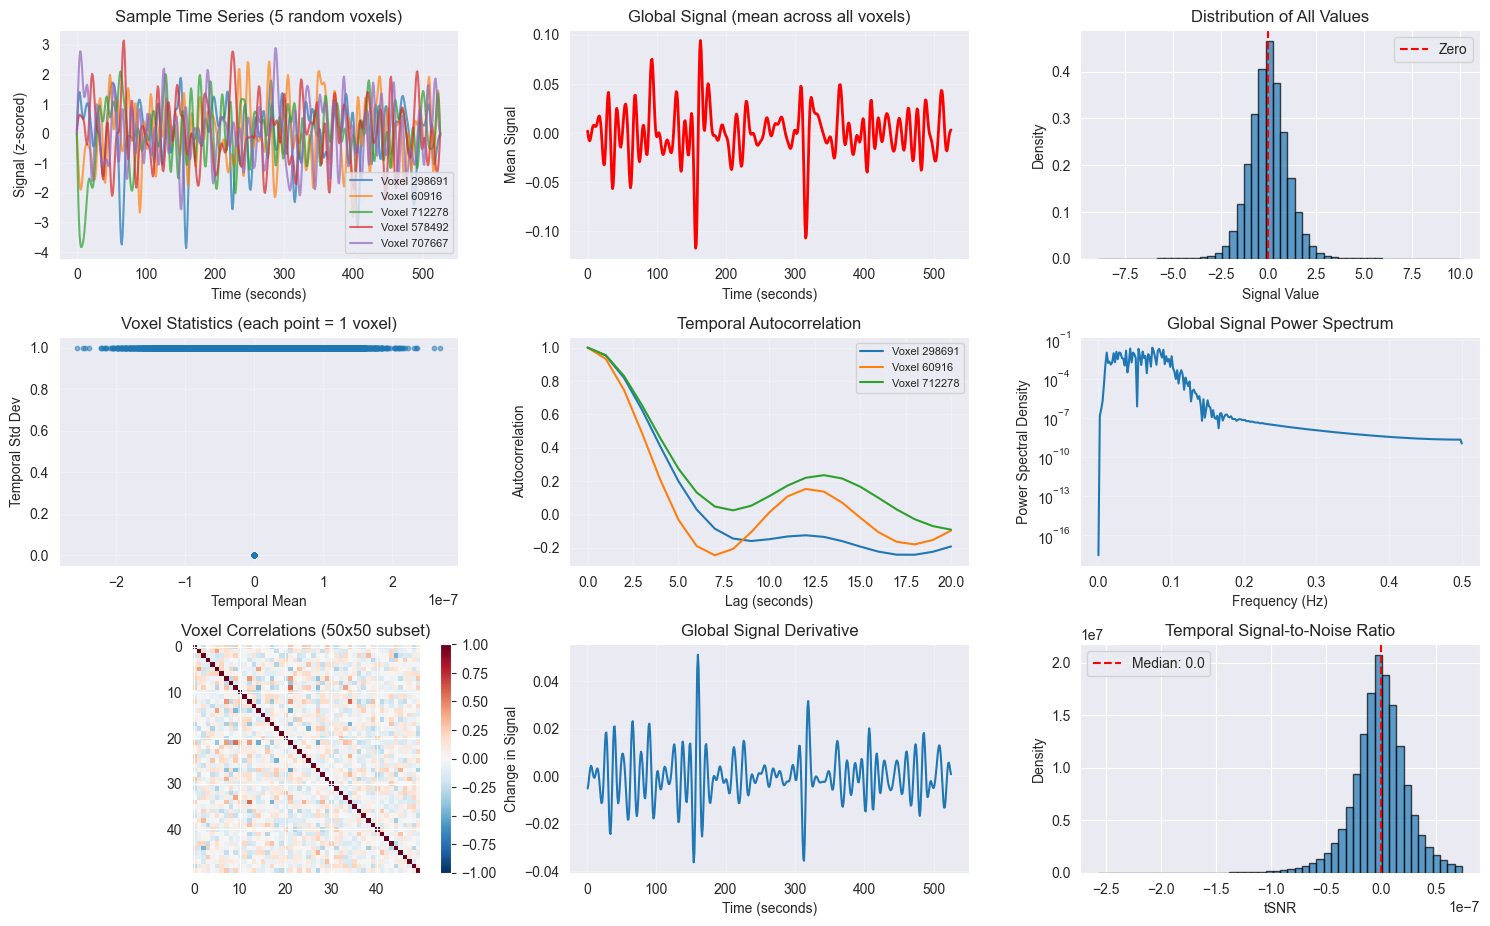


2. STATISTICAL SUMMARY:
     Metric        Global
0      Mean  8.556469e-10
1   Std Dev  9.952185e-01
2       Min -8.873975e+00
3       Max  1.010108e+01
4  Skewness  7.592437e-02
5  Kurtosis  1.519530e+00

3. QUALITY CHECKS:
   - Zero-mean check: PASS
   - Unit variance check: PASS
   - Outliers (>3 std): 3097262 values (0.81%)
   - Constant voxels: 6927 voxels


/var/folders/97/24ncl4qd53x6f62kxbdsk5f80000gn/T/ipykernel_30653/437948712.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



4. MASK STATISTICS:
   - Total voxels in image: 726,000
   - Brain voxels (included): 725,886
   - Coverage: 100.0%
   - Mask dimensions: (110, 110, 60)

5. PREPROCESSING EFFECTS:
   - Raw signal range: [233.00, 458.00]
   - Preprocessed range: [-2.49, 3.34]
   - Raw mean: 362.96
   - Preprocessed mean: 0.00
   - Raw std: 32.64
   - Preprocessed std: 1.00

DATA INSPECTION COMPLETE

Next steps:
1. Review the plots to ensure data quality
2. Check for any anomalies or artifacts
3. Proceed with CEBRA preparation if data looks good
4. Consider adjusting preprocessing parameters if needed


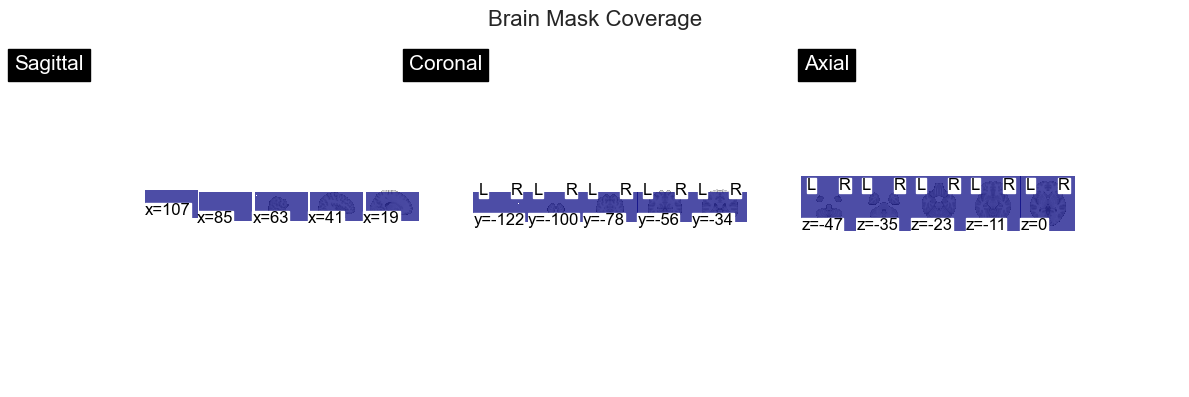

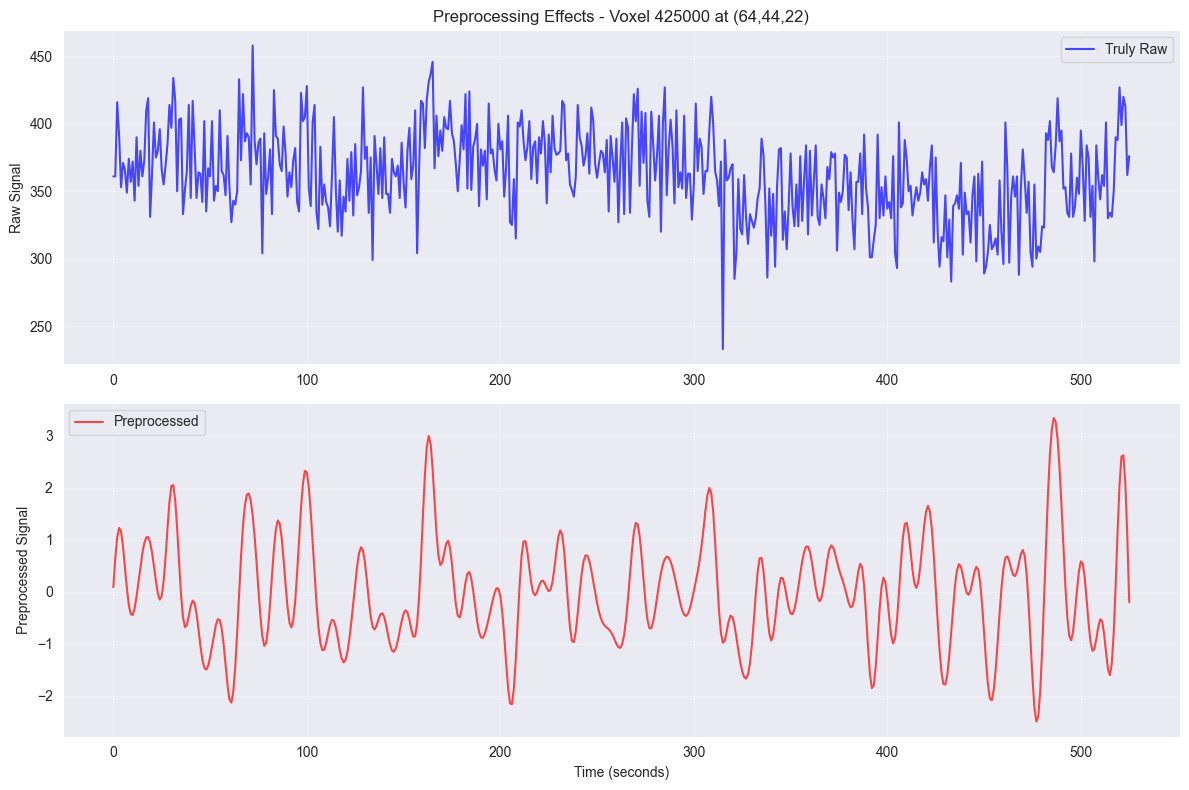

In [27]:
fig1, stats_df = inspect_fmri_data(time_series, masker, tr=CONFIG['tr'])

fig2 = visualize_mask_coverage(masker)

fig3 = compare_raw_vs_preprocessed(CONFIG['nifti_file'], masker)

print("\n" + "="*50)
print("DATA INSPECTION COMPLETE")
print("="*50)
print("\nNext steps:")
print("1. Review the plots to ensure data quality")
print("2. Check for any anomalies or artifacts")
print("3. Proceed with CEBRA preparation if data looks good")
print("4. Consider adjusting preprocessing parameters if needed")